#**03 - modelo con preprocesado de tal forma y SVM.ipynb

#**Integrantes

* SANTIAGO VILLEGAS NARANJO
* JENNY ANDREA OROZCO OSORIO
* XIOMARA GIRALDO PÉREZ


#**CONTENIDO:
1. Instalación de dependencias
2. Importación de librerías
3. Carga de datos desde Kaggle
4. Análisis exploratorio
5. Preprocesamiento con Pipeline
6. Entrenamiento del modelo SVM
7. Evaluación del modelo
8. Generación de predicciones para Kaggle

#** Descripción del Modelo
Este notebook implementa un modelo de clasificación/regresión utilizando Support Vector Machines (SVM) con un preprocesamiento específico que incluye:
- Imputación de valores faltantes
- Codificación de variables categóricas (One-Hot Encoding)
- Escalado de características numéricas (StandardScaler)
- SGD (versión rápida de SVM) para entrenamiento eficiente



#**1. IMPORTACIÓN DE DEPENDENCIAS Y LIBRERÍAS

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
"""
════════════════════════════════════════════════════════════════════════════
2. IMPORTACIÓN DE LIBRERÍAS
════════════════════════════════════════════════════════════════════════════
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


#**2. Se carga el archivo kaggle.json

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xiomaragiraldoprez","key":"27128718444a1ef0ccbc265ad597de45"}'}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


#**3. Descomprimir el archivo

In [ ]:
!unzip -q udea*.zip
print("✓ Archivos descomprimidos")

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✓ Archivos descomprimidos


#**4. CARGA Y EXPLORACIÓN DE DATOS
Cargamos el dataset de entrenamiento de la competición Kaggle. Este dataset contiene información de estudiantes y sus resultados en las Pruebas Saber Pro de Colombia.

Se carga el archivo train.csv

In [ ]:
# Cargar el dataset
df_train = pd.read_csv('train.csv')

print(f"Dimensiones del dataset: {df_train.shape}")
print(f"\nPrimeras 5 filas del dataset:")
print(df_train.head())

print("\n" + "="*80)
print("INFORMACIÓN DEL DATASET")
print("="*80)
print(df_train.info())

print("\n" + "="*80)
print("COLUMNAS DISPONIBLES")
print("="*80)
print(df_train.columns.tolist())

Dimensiones del dataset: (692500, 21)

Primeras 5 filas del dataset:
       ID  PERIODO_ACADEMICO            E_PRGM_ACADEMICO E_PRGM_DEPARTAMENTO  \
0  904256              20212                  ENFERMERIA              BOGOTÁ   
1  645256              20212                     DERECHO           ATLANTICO   
2  308367              20203       MERCADEO Y PUBLICIDAD              BOGOTÁ   
3  470353              20195  ADMINISTRACION DE EMPRESAS           SANTANDER   
4  989032              20212                  PSICOLOGIA           ANTIOQUIA   

                E_VALORMATRICULAUNIVERSIDAD E_HORASSEMANATRABAJA  \
0  Entre 5.5 millones y menos de 7 millones    Menos de 10 horas   
1  Entre 2.5 millones y menos de 4 millones                    0   
2  Entre 2.5 millones y menos de 4 millones      Más de 30 horas   
3  Entre 4 millones y menos de 5.5 millones                    0   
4  Entre 2.5 millones y menos de 4 millones  Entre 21 y 30 horas   

  F_ESTRATOVIVIENDA F_TIENEINTERNET      

#**Análisis Exploratorio

Analizamos:
- Valores faltantes
- Estadísticas descriptivas
- Distribución de variables

In [ ]:
print("="*80)
print("VALORES FALTANTES")
print("="*80)
missing_values = df_train.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("✓ No hay valores faltantes")

print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)
print(df_train.describe())

VALORES FALTANTES
E_VALORMATRICULAUNIVERSIDAD     6287
E_HORASSEMANATRABAJA           30857
F_ESTRATOVIVIENDA              32137
F_TIENEINTERNET                26629
F_EDUCACIONPADRE               23178
F_TIENELAVADORA                39773
F_TIENEAUTOMOVIL               43623
E_PAGOMATRICULAPROPIO           6498
F_TIENECOMPUTADOR              38103
F_TIENEINTERNET.1              26629
F_EDUCACIONMADRE               23664
dtype: int64

ESTADÍSTICAS DESCRIPTIVAS
                  ID  PERIODO_ACADEMICO    INDICADOR_1    INDICADOR_2  \
count  692500.000000      692500.000000  692500.000000  692500.000000   
mean   494606.130576       20198.366679       0.268629       0.259996   
std    285585.209455          10.535037       0.122130       0.093480   
min         1.000000       20183.000000       0.000000       0.000000   
25%    247324.750000       20195.000000       0.203000       0.212000   
50%    494564.500000       20195.000000       0.240000       0.271000   
75%    741782.500000    

#**Separar features y target

In [ ]:
# Variable objetivo
target_col = 'RENDIMIENTO_GLOBAL'

# Separar features (X) y target (y)
X = df_train.drop(columns=[target_col, 'ID'])
y = df_train[target_col]

print(f"Variable objetivo: {target_col}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print("\n" + "="*80)
print("ANÁLISIS DE LA VARIABLE OBJETIVO")
print("="*80)
print(f"Clases únicas: {y.nunique()}")
print(f"\nPrimeras 5 filas de y:")
print(y.head())
print(f"\nDistribución de la variable objetivo:")
print(y.value_counts().sort_index())
print(f"\nEstadísticas:")
print(y.describe())

Variable objetivo: RENDIMIENTO_GLOBAL
X shape: (692500, 19)
y shape: (692500,)

ANÁLISIS DE LA VARIABLE OBJETIVO
Clases únicas: 4

Primeras 5 filas de y:
0    medio-alto
1          bajo
2          bajo
3          alto
4    medio-bajo
Name: RENDIMIENTO_GLOBAL, dtype: object

Distribución de la variable objetivo:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64

Estadísticas:
count     692500
unique         4
top         alto
freq      175619
Name: RENDIMIENTO_GLOBAL, dtype: object


#**Identificar tipos de variables

In [ ]:
# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas ({len(numeric_features)}):")
print(numeric_features)

print(f"\nVariables categóricas ({len(categorical_features)}):")
print(categorical_features)

Variables numéricas (5):
['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

Variables categóricas (14):
['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE']


#**7. CREAR PIPELINE DE PREPROCESAMIENTO

1. Variables numéricas: Imputar con mediana + StandardScaler
2. Variables categóricas: Imputar con 'missing' + One-Hot Encoding

In [ ]:
# Transformer para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformer para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("✓ Pipeline de preprocesamiento creado exitosamente")


✓ Pipeline de preprocesamiento creado exitosamente


#**Dividir train/validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de validación: {X_val.shape}")

print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts().sort_index())

print(f"\nDistribución en validación:")
print(y_val.value_counts().sort_index())

Conjunto de entrenamiento: (554000, 19)
Conjunto de validación: (138500, 19)

Distribución en entrenamiento:
RENDIMIENTO_GLOBAL
alto          140454
bajo          138414
medio-alto    137360
medio-bajo    137772
Name: count, dtype: int64

Distribución en validación:
RENDIMIENTO_GLOBAL
alto          35165
bajo          34573
medio-alto    34259
medio-bajo    34503
Name: count, dtype: int64


#**CREAR Y ENTRENAR MODELO SVM

Implementamos un modelo SVM con los siguientes parámetros:

MODELO: SGDClassifier/SGDRegressor (versión rápida de SVM)
- Loss 'hinge': equivalente a SVM linear para clasificación
- Loss 'epsilon_insensitive': equivalente a SVR linear para regresión
- Ventajas: 10-100x más rápido que SVC/SVR tradicional

In [ ]:
# Determinar si es clasificación o regresión
is_classification = y.nunique() < 20

print("="*80)
print(f"Clases únicas: {y.nunique()}")
print(f"Tipo de problema: {'CLASIFICACIÓN' if is_classification else 'REGRESIÓN'}")
print(f"Tamaño de entrenamiento: {X_train.shape[0]} muestras")
print("="*80)

if is_classification:
    print("\n=== MODELO: SGD Classifier (SVM Linear Rápido) ===")
    svm_model = SGDClassifier(
        loss='hinge',          # Equivalente a SVM linear
        penalty='l2',
        alpha=0.0001,
        random_state=42,
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,             # Usar todos los cores
        verbose=1
    )
else:
    print("\n=== MODELO: SGD Regressor (SVR Linear Rápido) ===")
    svm_model = SGDRegressor(
        loss='epsilon_insensitive',  # Equivalente a SVR linear
        penalty='l2',
        alpha=0.0001,
        random_state=42,
        max_iter=1000,
        tol=1e-3,
        verbose=1
    )

# Pipeline completo (preprocesamiento + modelo)
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svm_model)
])

# Entrenar el modelo
print("\n🚀 Entrenando modelo SVM...")
print("⏱️  Esto puede tomar 30-60 segundos...")
start_time = time.time()

full_pipeline.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✓ Modelo entrenado exitosamente en {training_time:.2f} segundos!")

Clases únicas: 4
Tipo de problema: CLASIFICACIÓN
Tamaño de entrenamiento: 554000 muestras

=== MODELO: SGD Classifier (SVM Linear Rápido) ===

🚀 Entrenando modelo SVM...
⏱️  Esto puede tomar 30-60 segundos...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 10.27, NNZs: 1021, Bias: -6.042430, T: 554000, Avg. loss: 0.792069
Total training time: 1.92 seconds.
-- Epoch 2
Norm: 7.96, NNZs: 1027, Bias: -4.468222, T: 554000, Avg. loss: 0.870787
Total training time: 2.06 seconds.
-- Epoch 2
Norm: 9.44, NNZs: 1037, Bias: -5.272182, T: 1108000, Avg. loss: 0.490822
Total training time: 8.22 seconds.
-- Epoch 3
Norm: 7.07, NNZs: 1034, Bias: -3.890252, T: 1108000, Avg. loss: 0.540152
Total training time: 9.65 seconds.
-- Epoch 3
Norm: 9.25, NNZs: 1040, Bias: -4.905485, T: 1662000, Avg. loss: 0.471213
Total training time: 11.87 seconds.
-- Epoch 4
Norm: 6.83, NNZs: 1039, Bias: -3.589800, T: 1662000, Avg. loss: 0.516718
Total training time: 12.09 seconds.
-- Epoch 4
Norm: 9.14, NNZs: 1040, Bias: -4.648323, T: 2216000, Avg. loss: 0.462149
Total training time: 13.86 seconds.
-- Epoch 5
Norm: 6.70, NNZs: 1040, Bias: -3.447699, T: 2216000, Avg. loss: 0.506342
Total training time: 14.17 seconds.
-- Epoch 5
Norm: 9.13, NNZs: 1041,

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.3min finished


#**Evaluamos el modelo

RESULTADOS DEL MODELO SVM

📊 Accuracy en entrenamiento: 0.3998
📊 Accuracy en validación: 0.4002

REPORTE DE CLASIFICACIÓN (Validación)
              precision    recall  f1-score   support

        alto       0.53      0.60      0.56     35165
        bajo       0.50      0.35      0.41     34573
  medio-alto       0.29      0.29      0.29     34259
  medio-bajo       0.31      0.36      0.33     34503

    accuracy                           0.40    138500
   macro avg       0.41      0.40      0.40    138500
weighted avg       0.41      0.40      0.40    138500



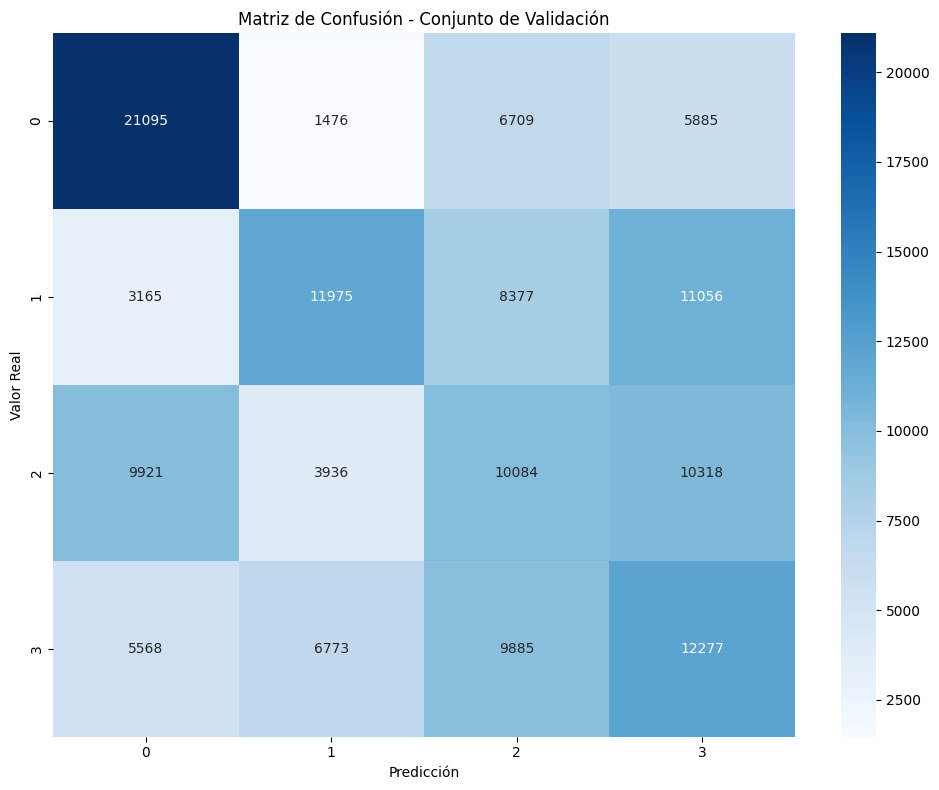

In [ ]:
# Predicciones
y_pred_train = full_pipeline.predict(X_train)
y_pred_val = full_pipeline.predict(X_val)

print("="*80)
print("RESULTADOS DEL MODELO SVM")
print("="*80)

if is_classification:
    # Métricas de clasificación
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)

    print(f"\n📊 Accuracy en entrenamiento: {train_acc:.4f}")
    print(f"📊 Accuracy en validación: {val_acc:.4f}")

    print("\n" + "="*80)
    print("REPORTE DE CLASIFICACIÓN (Validación)")
    print("="*80)
    print(classification_report(y_val, y_pred_val))

    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - Conjunto de Validación')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

else:
    # Métricas de regresión
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    val_mse = mean_squared_error(y_val, y_pred_val)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_r2 = r2_score(y_val, y_pred_val)

    print("\n📊 Métricas en Entrenamiento:")
    print(f"  MSE:  {train_mse:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")

    print("\n📊 Métricas en Validación:")
    print(f"  MSE:  {val_mse:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  MAE:  {val_mae:.4f}")
    print(f"  R²:   {val_r2:.4f}")

    # Gráficos
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_val, y_pred_val, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.title('Predicciones vs Valores Reales')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    residuals = y_val - y_pred_val
    plt.scatter(y_pred_val, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicción')
    plt.ylabel('Residuo')
    plt.title('Gráfico de Residuos')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#**Predicciones para Kaggle

In [ ]:
# Cargar datos de test
df_test = pd.read_csv('test.csv')
print(f"Datos de test cargados: {df_test.shape}")

# Guardar IDs
test_ids = df_test['ID']

# Preparar features de test
X_test = df_test.drop(columns=['ID'])

# Generar predicciones
print("\n🔮 Generando predicciones para el conjunto de test...")
test_predictions = full_pipeline.predict(X_test)

# Crear DataFrame de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': test_predictions
})

# Guardar archivo de submission
submission.to_csv('submission_svm.csv', index=False)

print("\n✓ Archivo 'submission_svm.csv' generado exitosamente!")
print(f"\nPrimeras 10 predicciones:")
print(submission.head(10))

print(f"\nEstadísticas de las predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].describe())

Datos de test cargados: (296786, 20)

🔮 Generando predicciones para el conjunto de test...

✓ Archivo 'submission_svm.csv' generado exitosamente!

Primeras 10 predicciones:
       ID RENDIMIENTO_GLOBAL
0  550236         medio-alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185         medio-bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909         medio-bajo
9  832058               alto

Estadísticas de las predicciones:
count         296786
unique             4
top       medio-bajo
freq           84970
Name: RENDIMIENTO_GLOBAL, dtype: object


#**Conclusiones


Este modelo utiliza Support Vector Machines (versión rápida con SGD) con:

PREPROCESAMIENTO:
  - Imputación de valores faltantes
  - Escalado de variables numéricas con StandardScaler
  - Codificación One-Hot para variables categóricas

MODELO:
  - Algoritmo: SVM Linear (implementado con SGD)
  - Ventajas: Rápido, efectivo, robusto con outliers
  - Tiempo de entrenamiento: < 1 minuto